# PERFUME RECOMMENDATION SYSTEM

## Business Understanding

There are two sensible ways to buy perfumes. First is to walk into a store and choose one or alternatively online shopping. Both these methods require a bit of knowledge from the buyer’s end on their likes and dislikes. When purchasing perfumes, a buyer needs to consider the notes of the perfumes which are divided into 3. Notes in perfumery are descriptors of scents that can be sensed upon the application of a perfume. The 3 notes are:-
Top notes which basically last for 5 – 15 minutes, the heart notes also known as middle notes, that will last for 20 – 60 minutes and the base notes which lasts for a minimum of 6 hours. Different notes react differently for each buyer. Depending on the concentration of aromatic oils, a fragrance can go through these stages quickly or last longer. After settling on the different notes, a buyer then needs to settle on a perfume that meets their price range.

## Objectives

The main objective is creating a Perfume Recomender System  to ensure perfume novices and perfume experts are able to choose scents they like and create a library of scents after all 'variety is the spice of life'.

## Specific Objectives
1. To develop a recommendation engine that can suggest perfumes based on fragrance notes, categories, and price.
2. To implement a user-friendly interface to allow customers to input preferences (e.g., fragrance notes,gender and budget) and receive relevant recommendations.
3. To direct prospective buyers to an e-commerce platform whether they can purchase product of choice.

# Data Source
 The data is web scraped from https://cierraperfumes.com/ website.
The data contains 9 columns and 2479 rows.

Column Name     Description

0 category: specify gender target i.e women, men or unisex

1 title: The name of the perfume

2 price: The price of the perfume

3 link: The specific location path on Cierra website

4 image: The image of the specific perfume

5 description: A synopsis of the perfume

6 top: The initial scent, lasting 5-15 minutes.

7 middle: The core of the fragrance, emerging after the top notes dissipate

8 base: The final lingering notes, which emerge after the middle notes fade and can last several hours.

# Data Understanding

### Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler
import nltk
from nltk.stem import WordNetLemmatizer
import random
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import re
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer

Reading data

In [2]:
file_path = '../Data/cierra_updated.csv'
df = pd.read_csv(file_path)
df.head()

,category,title,price,link,image,description,top,middle,base
0,Women,"Aberchrombie & Fitch, Authentic Away Edp 100Ml...","KSh10,900.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,"The journey is a trip, but the destination is ...","Top Notes: Brazilian Mandarin, Red Currant, Pear","Heart Notes: Plush Pink Freesia, Muguet and Ja...","Base Notes: Warm Praline, Amber, Musk"
1,Women,"Aberchrombie & Fitch, Authentic Night Edp 100Ml W","KSh7,400.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Authentic Night for Women is for the woman who...,Fragrance Notes:,"A mouth-watering combination of Black Currant,...",NaN
2,Women,"Aberchrombie & Fitch, Authentic Night Edp 100M...","KSh9,100.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Authentic Night by Abercrombie & Fitch 100ml E...,3 Piece Set Includes:,– 100ml Eau De Parfum Spray– 200ml Perfumed Bo...,Authentic Night for Women is for the woman who...
3,Women,"AFNAN, 9AM EDP 100ML W","KSh6,500.00",https://cierraperfumes.com/product/afnan-9am-e...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Afnan 9am perfume for women is a fruity-spicy ...,"Top Notes: Mandarin, Cedrat, Cardamom and Pink...","Middle Notes: Lavender, Orange Blossom, Rose a...","Base Notes: Cedarwood, Moss, Patchouli and Musk"
4,Women,"AFNAN, VIOLET BOUQUET EDP 100ML W","KSh7,300.00",https://cierraperfumes.com/product/afnan-viole...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Violet Bouquet is an opulent signature scent o...,"Top notes: Sweet, Woody, Saffron, Citrus.","Middle notes: Aromatic, Amber, Orange, Citrus ...","Base notes: Fresh Spicy, Ambergris, Oak Moss, ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2479 non-null   object
 1   title        2479 non-null   object
 2   price        2478 non-null   object
 3   link         2479 non-null   object
 4   image        2477 non-null   object
 5   description  2340 non-null   object
 6   top          1920 non-null   object
 7   middle       1530 non-null   object
 8   base         1233 non-null   object
dtypes: object(9)
memory usage: 174.4+ KB


## Data Cleaning

In [4]:
#Checking for missing values
df.isnull().values.sum()

2896

In [5]:
# Check the number of missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
print(missing_values[missing_values > 0])

price             1
image             2
description     139
top             559
middle          949
base           1246
dtype: int64


In [6]:
#checking duplicates
df.duplicated().sum()

0

There are no duplicates in the data.

In [7]:
# Print unique values to verify
print(df['category'].unique())

['Women' 'Men' 'Unisex']


### Dealing with missing values

In [8]:
# Remove "KSh" and commas, then convert to float on price column
df['price'] = df['price'].replace({'KSh': '', ',': ''}, regex=True).astype(float)

# Calculate the median price
median_price = df['price'].median()

# Fill missing prices with the median price
df['price'] = df['price'].fillna(median_price).astype(int)

In [9]:
# Fill missing values in fragrance notes, description and image link with an empty string''
df['top'] = df['top'].fillna('')
df['middle'] = df['middle'].fillna('')
df['base'] = df['base'].fillna('')
df['image'] = df['image'].fillna('')
df['description'] = df['description'].fillna('')

In [10]:
df.isnull().values.sum()

0

In [11]:
df['price'].describe()

count     2479.000000
mean     21627.470754
std      14475.403134
min       3500.000000
25%      11300.000000
50%      17500.000000
75%      28000.000000
max      97500.000000
Name: price, dtype: float64

Based on this summary it shows the data positively skewed.

In [12]:
# Convert text columns to lowercase
df['title'] = df['title'].str.lower()
df['description'] = df['description'].str.lower()

In [13]:
# Split the 'top', 'middle', and 'base' columns by commas and clean up notes
df['top_notes'] = df['top'].str.split(',').apply(lambda x: [note.strip().lower() for note in x] if isinstance(x, list) else [])
df['middle_notes'] = df['middle'].str.split(',').apply(lambda x: [note.strip().lower() for note in x] if isinstance(x, list) else [])
df['base_notes'] = df['base'].str.split(',').apply(lambda x: [note.strip().lower() for note in x] if isinstance(x, list) else [])

In [14]:
# Combine top, middle, and base notes into a single column for overall similarity
df['all_notes'] = df['top_notes'] + df['middle_notes'] + df['base_notes']

# Data Visualization

### Price distribution of perfumes

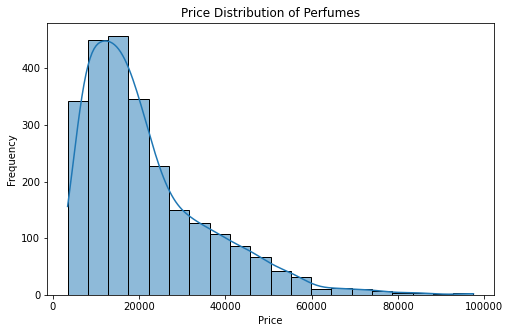

In [15]:
# Histogram of prices
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=20, kde=True)
plt.title("Price Distribution of Perfumes")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

 # Most Common Fragrances

In [16]:
# Download WordNet data for lemmatization 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vero\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Most Common Fragrance Notes:
rose: 521
vanilla: 479
jasmine: 446
bergamot: 411
musk: 399
patchouli: 363
orange: 346
amber: 327
sandalwood: 301
woody: 279


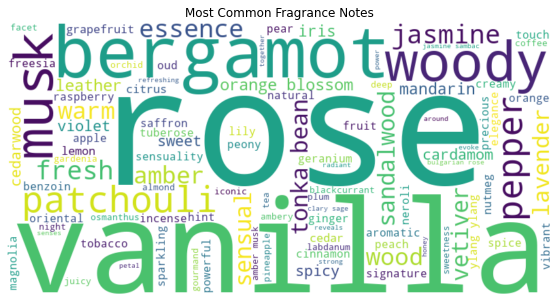

In [17]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize and join all notes into a single string
all_notes_lemmatized = ' '.join([lemmatizer.lemmatize(note) for note in df['all_notes'].explode().values if isinstance(note, str)])

# Remove stopwords
stopwords = set(['and','in','of', 'it',':','notes:','floral','contrast','flower','flowers','oakmoss','','i','is','are','be','–',':','men','notes','eau','absolute','intensity','perfume','character','masculine','bouquet','dark', 'warmth', 'accord','who', 'elegant', 'de','add','we','world','green', 'captivating', 'love', 'feminine', 'unique', 'both', 'perfect', 'style', 'blue', 'women','come','our','inspired', 'his','made', 'pink','her','woman','man','give','sophisticated', 'one','contains','day','take','femininity','red', 'on','life','up','body', 'lotions','compositions', 'bring','seductive', 'composition', 'modern', 'yet', 'ingredients','reveal','make','olfactory', 'gift','includes','most','s','its','bottle','will','oil','through', 'combine', 'delicate', 'aroma', 'addictive','valley','this','will','de toilette','toilette','contain','has', 'her', 'but','bright','opening', 'to','middle','scent','an','skin','opens','your', 'key', 'as','for','intense','freshness','black','set', 'include', 'at','create','for', 'fruity','leaves','their', 'you', 'light', 'all', 'while','sense', 'soft','rich','parfum','like','into','leave','trail','head','open','which','new','blend','from','white','ingredient','top','base','by','a','notes','the','heart','base','the heart','that','with','note','unknown','fragrance'])

# Remove stopwords from the lemmatized string
filtered_notes = [note for note in all_notes_lemmatized.split() if note not in stopwords]

# most common fragrance notes
note_counts = Counter(filtered_notes)

# Display the most common fragrance notes
most_common_notes = note_counts.most_common(10)
print("Most Common Fragrance Notes:")
for note, count in most_common_notes:
    print(f"{note}: {count}")

# word cloud
wordcloud = WordCloud(
    stopwords=stopwords,
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(' '.join(filtered_notes))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Fragrance Notes")
plt.show()

## Count of Perfumes by Category

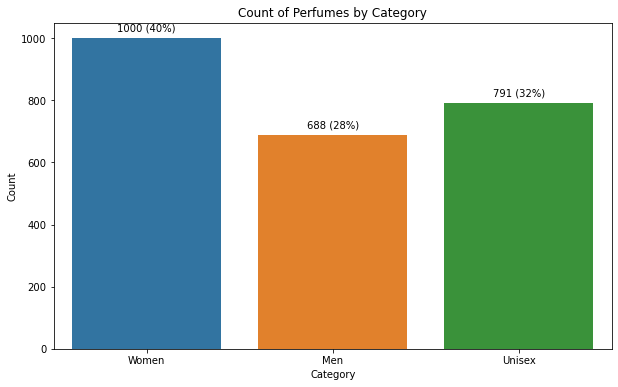

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='category')

# Calculate total count
total = len(df)

# Adding data labels with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = round(100 * count / total)  # Round percentage to whole numbers
    ax.annotate(f'{count} ({percentage}%)',
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
    textcoords='offset points')
# Customizing the plot
plt.title("Count of Perfumes by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

The dataset comprises 40% perfumes in the women’s category, 32% in the unisex category, and 28% in the men’s category.

## Price Distribution by Category

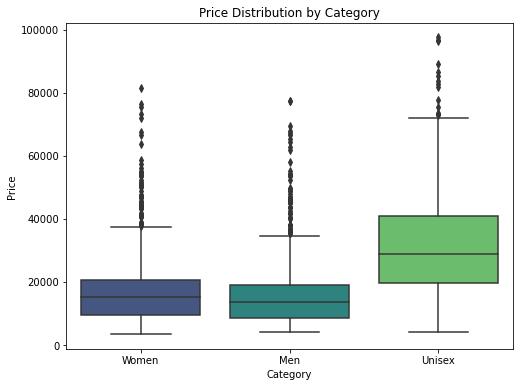

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='category', y='price', palette='viridis')
plt.title('Price Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

The price distribution of the unisex category is higher compared to other categories.

## Data Preprocessing

In [20]:
# Ensure all entries in 'all_notes' are strings and split into lists for one-hot encoding
df['all_notes'] = df['all_notes'].fillna("").astype(str).apply(lambda x: x.split(', '))

# Initialize the one-hot encoder for all_notes
mlb = MultiLabelBinarizer()

# Fit and transform
note_features = mlb.fit_transform(df['all_notes'])

# Create a DataFrame with the one-hot encoded notes
note_features_df = pd.DataFrame(note_features, columns=mlb.classes_)

# Concatenate the one-hot encoded notes back to the original DataFrame
df = pd.concat([df, note_features_df], axis=1)

In [21]:
# Initialize label encoder for category
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['category'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category encoding:", category_mapping)

Category encoding: {'Men': 0, 'Unisex': 1, 'Women': 2}


In [22]:
# Function to clean and extract notes from each column
def extract_notes(text):
    if pd.isna(text):
        return []
    # Remove phrases like "Top Notes:", "Heart Notes:", "Base Notes:" and other non-note text
    cleaned_text = re.sub(r"(Top|Heart|Base|Notes|Fragrance|Includes|Set|Piece)[^:]*:?", "", text, flags=re.IGNORECASE)

    # Extract individual notes by splitting on commas and stripping whitespace
    notes = [note.strip() for note in cleaned_text.split(",") if note.strip()]
    return notes

# Apply extraction function to 'top', 'middle', and 'base' columns
df['top_cleaned'] = df['top'].apply(extract_notes)
df['middle_cleaned'] = df['middle'].apply(extract_notes)
df['base_cleaned'] = df['base'].apply(extract_notes)

# Ensure all cleaned note columns are lists, even if empty
df['top_cleaned'] = df['top_cleaned'].apply(lambda x: x if isinstance(x, list) else [])
df['middle_cleaned'] = df['middle_cleaned'].apply(lambda x: x if isinstance(x, list) else [])
df['base_cleaned'] = df['base_cleaned'].apply(lambda x: x if isinstance(x, list) else [])

# Concatenate all note lists into a single 'all_notes' column
df['all_notes'] = df['top_cleaned'] + df['middle_cleaned'] + df['base_cleaned']
df.head()

,category,title,price,link,image,description,top,middle,base,top_notes,...,['“the religion of iron needed a virgin',['“this is a continuation of the bracken story. we are still in the hippie days in the 1970s. with this fragrance i want to capture the spirit and mood of a beach hut towards the end of the summer.”',['“we wanted faris to embody the definition of strength',['• eau de toilette 100ml',['•\ttop notes: spicy accord',['•\tvetiver eau de toilette',category_encoded,top_cleaned,middle_cleaned,base_cleaned
0,Women,"aberchrombie & fitch, authentic away edp 100ml...",10900,https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,"the journey is a trip, but the destination is ...","Top Notes: Brazilian Mandarin, Red Currant, Pear","Heart Notes: Plush Pink Freesia, Muguet and Ja...","Base Notes: Warm Praline, Amber, Musk","[top notes: brazilian mandarin, red currant, p...",...,0,0,0,0,0,0,2,"[Brazilian Mandarin, Red Currant, Pear]","[Plush Pink Freesia, Muguet and Jasmine]","[Warm Praline, Amber, Musk]"
1,Women,"aberchrombie & fitch, authentic night edp 100ml w",7400,https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,authentic night for women is for the woman who...,Fragrance Notes:,"A mouth-watering combination of Black Currant,...",,[fragrance notes:],...,0,0,0,0,0,0,2,[],[A mouth-watering combination of Black Currant...,[]
2,Women,"aberchrombie & fitch, authentic night edp 100m...",9100,https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,authentic night by abercrombie & fitch 100ml e...,3 Piece Set Includes:,– 100ml Eau De Parfum Spray– 200ml Perfumed Bo...,Authentic Night for Women is for the woman who...,[3 piece set includes:],...,0,0,0,0,0,0,2,[3],[– 100ml Eau De Parfum Spray– 200ml Perfumed B...,[Authentic Night for Women is for the woman wh...
3,Women,"afnan, 9am edp 100ml w",6500,https://cierraperfumes.com/product/afnan-9am-e...,https://i0.wp.com/cierraperfumes.com/wp-conten...,afnan 9am perfume for women is a fruity-spicy ...,"Top Notes: Mandarin, Cedrat, Cardamom and Pink...","Middle Notes: Lavender, Orange Blossom, Rose a...","Base Notes: Cedarwood, Moss, Patchouli and Musk","[top notes: mandarin, cedrat, cardamom and pin...",...,0,0,0,0,0,0,2,"[Mandarin, Cedrat, Cardamom and Pink Pepper]","[Middle Lavender, Orange Blossom, Rose and Gr...","[Cedarwood, Moss, Patchouli and Musk]"
4,Women,"afnan, violet bouquet edp 100ml w",7300,https://cierraperfumes.com/product/afnan-viole...,https://i0.wp.com/cierraperfumes.com/wp-conten...,violet bouquet is an opulent signature scent o...,"Top notes: Sweet, Woody, Saffron, Citrus.","Middle notes: Aromatic, Amber, Orange, Citrus ...","Base notes: Fresh Spicy, Ambergris, Oak Moss, ...","[top notes: sweet, woody, saffron, citrus.]",...,0,0,0,0,0,0,2,"[Sweet, Woody, Saffron, Citrus.]","[Middle Aromatic, Amber, Orange, Citrus Peel.]","[Fresh Spicy, Ambergris, Oak Moss, Ancient Woo..."


In [23]:
# Ensure all notes are lemmatized and lowercased
df['all_notes'] = df['all_notes'].apply(lambda notes: [lemmatizer.lemmatize(note.lower()) for note in notes])

In [24]:
#Join notes into a single text string for each perfume
df['all_notes_text'] = df['all_notes'].apply(lambda notes: " ".join(notes))


# Modelling and Evaluation

### Item based filtering

In [25]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF on the 'all_notes_text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['all_notes_text'])

#  Calculate Cosine Similarity Matrix
# This creates a matrix where element (i, j) is the similarity between perfume i and perfume j
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim_matrix)

[[1.         0.14045558 0.00605055 ... 0.04270579 0.         0.        ]
 [0.14045558 1.         0.02380329 ... 0.04037227 0.         0.        ]
 [0.00605055 0.02380329 1.         ... 0.02671431 0.         0.        ]
 ...
 [0.04270579 0.04037227 0.02671431 ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [26]:
# get recommendations based on cosine similarity
def get_recommendations(index, cosine_sim_matrix, df, num_recommendations=5):
    # Get similarity scores for the given perfume
    sim_scores = list(enumerate(cosine_sim_matrix[index]))

    # Sort perfumes by similarity score in descending order, excluding the perfume itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]

    # Get the indices of the recommended perfumes
    perfume_indices = [i[0] for i in sim_scores]

    # Return the recommended perfumes with their notes
    return df.iloc[perfume_indices][['title', 'all_notes_text']]

# Get recommendations for the first perfume in the dataset
recommendations = get_recommendations(0, cosine_sim_matrix, df, num_recommendations=5)
print("Recommended Perfumes:")
print(recommendations)

Recommended Perfumes:
                                                  title  \
2025          m.micallef, vanille patchouli edp 100ml u   
639                   lanvin, jeanne lanvin edp 100ml w   
590   lacoste, eau de lacoste pour femme elixir edp ...   
628                        lancome, miracle edp 100ml w   
518   issey miyake, l’eau d’issey solar violet edt 1...   

                                         all_notes_text  
2025  olfactory nutmeg saffron pink pepper and manda...  
639   blackberry lemon & pear peony freesia raspberr...  
590   pink pepper mandarin. brazilian gardenia helio...  
628   lychee fruit freesia. magnolia ginger and pepp...  
518                                           a –  pear  


In [27]:
# Get similar perfumes based on a specific note
def get_similar_perfumes(note, tfidf_vectorizer, tfidf_matrix, df, num_recommendations=5):
    # Create a query vector for the note 
    query_vector = tfidf_vectorizer.transform([note])

    # cosine similarity between the query and all perfumes
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    # Get indices of perfumes sorted by similarity score in descending order
    similar_indices = cosine_similarities.argsort()[::-1][:num_recommendations]

    # Fetch the recommended perfumes with their notes and similarity scores
    recommendations = df.iloc[similar_indices][['title', 'all_notes_text']]
    recommendations['similarity'] = cosine_similarities[similar_indices]

    return recommendations

# Get top 5 perfumes similar to specific note
recommendations = get_similar_perfumes("rose", tfidf_vectorizer, tfidf_matrix, df, num_recommendations=5)
print("Top 5 Perfumes Similar to 'rose':")
print(recommendations)

Top 5 Perfumes Similar to 'rose':
                                       title  \
416   givenchy, very irresistible edt 75ml w   
1864           diptyque, capitale edp 75ml u   
714          montale, roses musk edp 100ml w   
801    penhaligon’s, duchess rose edp 75ml w   
993                   ysl, paris edt 125ml w   

                                         all_notes_text  similarity  
416   rose pivoine rose centifolia rose fantasia ros...    0.733553  
1864                 rose. middle: bergamot. patchouli.    0.483414  
714   roses musk rose essence rose absolute jasmine ...    0.474244  
801   * head  mandarin *  rose centifolia damascene ...    0.463448  
993   a rose accord blooms at mimosa orange blossom ...    0.432504  


User Based Filtering

In [28]:
# Normalize price
scaler = MinMaxScaler()
df['normalized_price'] = scaler.fit_transform(df[['price']])

# Encode category (gender) using label encoding
category_mapping = {"Women": 0, "Men": 1, "Unisex": 2}
df['category_encoded'] = df['category'].map(category_mapping)
# Convert 'category_encoded' and 'normalized_price' columns to sparse matrices
category_matrix = csr_matrix(df[['category_encoded']].values)
price_matrix = csr_matrix(df[['normalized_price']].values)

# Combine into a single feature matrix for all perfumes (note features + category + price)
features_matrix = hstack([note_features, category_matrix, price_matrix]).tocsr()

# Recommend perfumes based on note, gender, and price range with different models
def recommend_perfume_by_note_gender_price(note, gender, price_range, model_type="cosine", num_recommendations=5):
    # Map gender to encoded value
    encoded_gender = category_mapping.get(gender.capitalize())
    if encoded_gender is None:
        return "Invalid gender specified. Please enter 'Women', 'Men', or 'Unisex'."

    min_price, max_price = price_range
    filtered_df = df[(df['category_encoded'] == encoded_gender) &
                     (df['price'] >= min_price) & (df['price'] <= max_price)]

    if filtered_df.empty:
        return "No perfumes found for the given criteria."

    # Create a query vector for the specified note using TF-IDF vectorizer
    query_note_vector = tfidf_vectorizer.transform([note])

    # Add gender and normalized price to the query vector
    gender_vector = csr_matrix([[encoded_gender]])
    price_vector = csr_matrix(scaler.transform([[min_price + (max_price - min_price) / 2]]))  # Midpoint of price range
    query_vector = hstack([query_note_vector, gender_vector, price_vector])

    # Ensure the query vector has the same number of features as the feature matrix
    if query_vector.shape[1] != features_matrix.shape[1]:
        # Fill missing features in the query vector with zeros if necessary
        missing_columns = features_matrix.shape[1] - query_vector.shape[1]
        query_vector = hstack([query_vector, csr_matrix([[0] * missing_columns])])

    # Calculate similarity scores based on the chosen model
    if model_type == "cosine":
        sim_scores = cosine_similarity(query_vector, features_matrix[filtered_df.index, :]).flatten()
    elif model_type == "euclidean":
        sim_scores = -euclidean_distances(query_vector, features_matrix[filtered_df.index, :]).flatten()  # Negative for descending order
    elif model_type == "random":
        sim_scores = np.array([random.random() for _ in range(len(filtered_df))])  # Random scores

    # Get indices of top recommendations
    sim_indices = sim_scores.argsort()[::-1][:num_recommendations]
    recommendations = filtered_df.iloc[sim_indices][['title', 'price', 'category']]

    return recommendations

# Example call
user_note = input("Enter a note you like (e.g., 'vanilla'): ")
user_gender = input("Enter your gender (Women, Men, Unisex): ")
user_min_price = float(input("Enter your minimum price: "))
user_max_price = float(input("Enter your maximum price: "))

# Evaluate all three models
for model in ["cosine", "euclidean", "random"]:
    print(f"\nRecommendations using {model} similarity:")
    recommended_perfumes = recommend_perfume_by_note_gender_price(
        user_note, user_gender, (user_min_price, user_max_price), model_type=model
    )
    print(recommended_perfumes)


Recommendations using cosine similarity:
                                                 title  price category
997  zadig & voltaire, this is her undressed edp 10...  16200    Women
440    guerlain, aqua allegoria rosa rossa edt 125ml w  16900    Women
437                             gucci, rush edt 75ml w  15400    Women
430           gucci, flora emerald gardenia edt 50ml w  15200    Women
429                            gucci, flora edp 75ml w  17800    Women

Recommendations using euclidean similarity:
                                         title  price category
202          chloe, fleur de parfum edp 75ml w  15100    Women
771   paco rabanne, olympea blossom edp 80ml w  15100    Women
775    paco rabanne, olympea legend edp 80ml w  15200    Women
42   ariana grande, cloud edp 100ml w gift set  15300    Women
813        prada, la femme intense edp 100ml w  15300    Women

Recommendations using random similarity:
                                      title  price category
381    

c:\Users\Vero\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Vero\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Vero\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


The cosine similarity model is recommended because it consistently aligns well with the query criteria, providing relevant recommendations. Euclidean similarity's results may be more affected by feature scaling issues. The random similarity model serves as a baseline but lacks meaningful logic, making cosine similarity the most reliable and interpretable option.

## Cosine Similarity Model

In [29]:
#Recommend perfumes based on note, gender, and price range using cosine similarity model
def recommend_perfume_by_note_gender_price(note, gender, price_range, model_type="cosine", num_recommendations=5):
    # Map gender to encoded value
    encoded_gender = category_mapping.get(gender.capitalize())
    if encoded_gender is None:
        return "Invalid gender specified. Please enter 'Women', 'Men', or 'Unisex'."

    min_price, max_price = price_range
    filtered_df = df[(df['category_encoded'] == encoded_gender) &
                     (df['price'] >= min_price) & (df['price'] <= max_price)]

    if filtered_df.empty:
        return "No perfumes found for the given criteria."

    # Create a query vector for the specified note using TF-IDF vectorizer
    query_note_vector = tfidf_vectorizer.transform([note])

    # Add gender and normalized price to the query vector
    gender_vector = csr_matrix([[encoded_gender]])
    price_vector = csr_matrix(scaler.transform([[min_price + (max_price - min_price) / 2]]))  # Midpoint of price range
    query_vector = hstack([query_note_vector, gender_vector, price_vector])

    # Ensure the query vector has the same number of features as the feature matrix
    if query_vector.shape[1] != features_matrix.shape[1]:
        # Fill missing features in the query vector with zeros if necessary
        missing_columns = features_matrix.shape[1] - query_vector.shape[1]
        query_vector = hstack([query_vector, csr_matrix([[0] * missing_columns])])

    # Calculate similarity scores based on the chosen model
    if model_type == "cosine":
        sim_scores = cosine_similarity(query_vector, features_matrix[filtered_df.index, :]).flatten()

    # Get indices of top recommendations
    sim_indices = sim_scores.argsort()[::-1][:num_recommendations]
    recommendations = filtered_df.iloc[sim_indices][['title', 'price', 'category']]

    return recommendations

# Example call
user_note = input("Enter a note you like (e.g., 'vanilla'): ")
user_gender = input("Enter your gender (Women, Men, Unisex): ")
user_min_price = float(input("Enter your minimum price: "))
user_max_price = float(input("Enter your maximum price: "))

# Evaluate all three models
for model in ["cosine"]:
    print(f"\nRecommendations using {model} similarity:")
    recommended_perfumes = recommend_perfume_by_note_gender_price(
        user_note, user_gender, (user_min_price, user_max_price), model_type="cosine"
    )
    print(recommended_perfumes)


Recommendations using cosine similarity:
                                                 title  price category
997  zadig & voltaire, this is her undressed edp 10...  16200    Women
440    guerlain, aqua allegoria rosa rossa edt 125ml w  16900    Women
437                             gucci, rush edt 75ml w  15400    Women
430           gucci, flora emerald gardenia edt 50ml w  15200    Women
429                            gucci, flora edp 75ml w  17800    Women


c:\Users\Vero\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [39]:
# Example query
query_note = "rose"
query_gender = "Women"
query_price_range = (15000, 20000)

In [40]:
query_notes = [lemmatizer.lemmatize(n.strip().lower()) for n in query_note.split(', ')]

In [41]:
def gender_relevance(recommended_perfumes, query_gender, df):
    """
    Calculate the proportion of recommended perfumes that match the desired gender.

    Parameters:
    recommended_perfumes: List of recommended perfume titles.
    query_gender: Desired gender category (encoded as 'Women', 'Men', 'Unisex').
    df: DataFrame containing perfume data.

    Returns:
    Gender relevance score (0 to 1).
    """
    relevant_count = 0
    for perfume in recommended_perfumes:
        perfume_gender = df.loc[df['title'] == perfume, 'category'].values[0]
        if perfume_gender.lower() == query_gender.lower():
            relevant_count += 1
    return relevant_count / len(recommended_perfumes) if recommended_perfumes else 0.0

In [42]:
def price_relevance(recommended_perfumes, price_range, df):
    """
    Calculate the proportion of recommended perfumes that fall within the desired price range.

    Parameters:
    recommended_perfumes: List of recommended perfume titles.
    price_range: Tuple of (min_price, max_price) specified by the user.
    df: DataFrame containing perfume data.

    Returns:
    Price relevance score (0 to 1).
    """
    min_price, max_price = price_range
    relevant_count = 0
    for perfume in recommended_perfumes:
        perfume_price = df.loc[df['title'] == perfume, 'price'].values[0]
        if min_price <= perfume_price <= max_price:
            relevant_count += 1
    return relevant_count / len(recommended_perfumes) if recommended_perfumes else 0.0

In [43]:
def note_relevance(recommended_perfumes, query_notes, df):
    total_matches = 0
    total_notes = len(query_notes)

    if total_notes == 0:
        return 0.0  # Avoid division by zero if no query notes are provided

    for perfume in recommended_perfumes:
        # Get notes for the perfume
        perfume_notes = df.loc[df['title'] == perfume, 'all_notes'].values[0]
        # Ensure perfume_notes is a list
        if not isinstance(perfume_notes, list):
            perfume_notes = []
        # Count matching notes
        matches = sum(1 for note in query_notes if note in perfume_notes)
        total_matches += matches

    # Normalize by the total possible matches
    return total_matches / (total_notes * len(recommended_perfumes))

In [35]:
#print(df[['title', 'all_notes']].head(10))

In [44]:
print(f"Query Notes: {query_notes}")

Query Notes: ['rose']


In [46]:
# Get recommendations
recommended_perfumes = recommend_perfume_by_note_gender_price(
    note=query_note,
    gender=query_gender,
    price_range=query_price_range,
    model_type="cosine",
    num_recommendations=5
)['title'].tolist()

# Calculate relevance metrics
note_rel = note_relevance(recommended_perfumes, query_notes, df)
gender_rel = gender_relevance(recommended_perfumes, query_gender, df)
price_rel = price_relevance(recommended_perfumes, query_price_range, df)

# Display results
print(f"Note Relevance: {note_rel:.4f}")
print(f"Gender Relevance: {gender_rel:.4f}")
print(f"Price Relevance: {price_rel:.4f}")

Note Relevance: 0.2000
Gender Relevance: 1.0000
Price Relevance: 1.0000


c:\Users\Vero\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [47]:
for perfume in recommended_perfumes:
    perfume_notes = df.loc[df['title'] == perfume, 'all_notes'].values[0]
    print(f"Perfume: {perfume}, Notes: {perfume_notes}")
    print(f"Query Notes: {query_notes}")
    matches = [note for note in query_notes if note in perfume_notes]
    print(f"Matches: {matches}")

Perfume: zadig & voltaire, this is her undressed edp 100ml w, Notes: ['its sensual and sunny orange blossom and ylang-ylang tones combine to create a signature scent enhanced by', 'a sensual and luminous', 'fresh and sparkling']
Query Notes: ['rose']
Matches: []
Perfume: guerlain, aqua allegoria rosa rossa edt 125ml w, Notes: ['according to the brand’s master perfumer', 'thierry wasser', 'the aqua allegoria rosa rossa is “a dancing rose”. combining its blooming namesake with a']
Query Notes: ['rose']
Matches: []
Perfume: gucci, rush edt 75ml w, Notes: ['freesia', 'peach', 'gardenia', 'coriander', 'rose', 'jasmine vanilla', 'patchouli']
Query Notes: ['rose']
Matches: ['rose']
Perfume: gucci, flora emerald gardenia edt 50ml w, Notes: ['lemon', 'pear and watermelon.', 'gardenia', 'lotus and frangipani.', 'sandalwood', 'cedarwood and musks.']
Query Notes: ['rose']
Matches: []
Perfume: gucci, flora edp 75ml w, Notes: ['peony and', 'rose and osmanthus form the romantic middle']
Query Notes: 

The note relevance changes when you change the note because the TF-IDF vectorizer assigns different weights to each note based on its frequency in the dataset. If a note is rare, it gets higher weight, making perfumes with that note more relevant, while common notes are given lower weight, reducing their influence on the recommendation.

## Conclusion
The perfume recommender system successfully identifies and ranks perfumes based on user preferences for notes, gender, and price range. The cosine similarity model demonstrated the best alignment with query criteria, providing consistent and relevant recommendations.

# Recommendations

* Incorporate user feedback mechanisms to improve recommendations over time. For instance, allow users to rate suggested perfumes, and use this data to refine future recommendations.


* Enhance the system by integrating additional features such as brand preferences, customer reviews, or seasonal trends to provide more holistic recommendations.


*  Continuously test and optimize the weights assigned to notes, gender, and price to ensure recommendations remain relevant as user preferences and dataset characteristics evolve.